In [2]:
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = []
for i in range(10):
    event = (i+1)*200-1
    data.append(pd.read_csv('data'+str(event)+"_correct", index_col=0))

data = pd.concat(data, ignore_index=True)
df = data
df

,cluster_size,num_mips,min_y,min_z,max_y,max_z,layer,energy,eventID
0,1,1.0,999.0,199.0,999.0,199.0,0,0.002457,0
1,1,1.0,1000.0,200.0,1000.0,200.0,0,0.002457,0
2,1,1.0,993.0,162.0,993.0,162.0,1,0.002234,0
3,1,1.0,999.0,199.0,999.0,199.0,1,0.002625,0
4,1,1.0,1000.0,200.0,1000.0,200.0,1,0.009064,0
...,...,...,...,...,...,...,...,...,...
3313507,1,2.0,1327.0,362.0,1327.0,362.0,37,0.003174,1999
3313508,1,2.0,1345.0,67.0,1345.0,67.0,39,0.004639,1999
3313509,2,0.0,1399.0,72.0,1400.0,72.0,39,0.005127,1999
3313510,1,2.0,987.0,242.0,987.0,242.0,39,0.005066,1999


In [4]:
def trained_model(df):
    X = df.drop('num_mips', axis=1)
    y = df['num_mips']
    
    # Splitting data into training, validation, and test sets
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42) # This makes 60% train, 20% val, and 20% test

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9
    }

    num_round = 1500
    stop_rounds = 50
    evals_result = {}
    
    bst = lgb.train(params,
                    train_data,
                    num_boost_round=num_round,
                    valid_sets=[train_data, val_data],
                    early_stopping_rounds=stop_rounds,
                    evals_result=evals_result,
                    verbose_eval=10)
    
    # Predictions
    df_train = X_train.copy()
    df_train['num_mips'] = y_train
    df_train['predicted_mips_lgb'] = bst.predict(X_train)

    df_test = X_test.copy()
    df_test['num_mips'] = y_test
    df_test['predicted_mips_lgb'] = bst.predict(X_test)
    
    return bst, evals_result, df_train, df_test

def plot(bst, evals_result, df_train, df_test, test_size_fraction):
    # RMSE Plot
    plt.figure(figsize=(6,4))
    train_rmse = evals_result['training']['rmse']
    val_rmse = evals_result['valid_1']['rmse']
    plt.plot(train_rmse, label='Training RMSE', color='blue')
    plt.plot(val_rmse, label='Validation RMSE', color='red')
    plt.title('Training & Validation RMSE over Boosting Rounds')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2x3 grid of plots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # for a 2x3 grid
    
    # Plot 1: Residuals Plot for Training Data
    actual_vs_predicted_plot(df_test, axs[0, 0], test_size=100*(test_size_fraction), append=' - Testing Data')

    # Plot 2: Residuals Histogram for Training Data
    res_hist_plot(df_test, ax=axs[0, 1], test_size=100*(test_size_fraction), append=' - Testing Data')

    # Plot 3: Residuals Plot for Test Data
    residuals_plot(df_test, ax=axs[0, 2], test_size=100*test_size_fraction, append=' - Testing Data')

    # Plot 4: Binned Means for Training Data
    binned_stats_plot(df_test, ax=axs[1, 0], test_size=100*(test_size_fraction), append=' - Testing Data', bins = 40)

    # Plot 5: Binned Std for Training Data
    closure_stds_plot(df_test, ax=axs[1, 1], test_size=100*(test_size_fraction), append=' - Testing Data', bins = 40)
    
    # Plot 6: Feature Importance
    feature_plot(df_test, axs[1, 2], bst, test_size=100*(test_size_fraction), append=' - Testing Data')

    plt.tight_layout()
    plt.show()

# Assuming the other functions (`residuals_plot`, `res_hist_plot`, `feature_plot`, and `closure_std_plots`) remain the same.


In [5]:
def binned_stats_plot(df, ax, test_size=0, append='', bins=30):
    df = df.loc[:, ["num_mips", "predicted_mips_lgb"]]
    
    # Compute the ratio between predicted and actual
    df['ratio'] = df['predicted_mips_lgb'] / df['num_mips']

    # Bin the actual num_mips values
    df['bin'] = pd.cut(df['num_mips'], bins=bins, labels=False)

    # Group by the bin and calculate mean and standard deviation
    stats = df.groupby('bin').agg({'ratio': ['mean', 'std', 'count']}).reset_index()
    
    # Calculate the standard error of the mean
    stats[('ratio', 'sem')] = stats[('ratio', 'std')] / np.sqrt(stats[('ratio', 'count')])

    # Extract center of the bins for plotting
    bins_centers = df.groupby('bin')['num_mips'].mean().values

    # Plot the mean and SEM
    ax.errorbar(bins_centers, stats[('ratio', 'mean')], yerr=stats[('ratio', 'sem')], 
                fmt='-o', capsize=5, markersize=5, label='Mean with SEM')
    
    ax.axhline(y=1, color='red', linestyle='--')
    ax.set_xlabel('Actual num_mips')
    ax.set_ylabel('Predicted num_mips / Actual')
    ax.set_title(f'Binned Statistics (test size {test_size}%)' + append)
    ax.legend()
    ax.grid(True)

    # Adjusting the y-axis to center around 1
    ymin, ymax = ax.get_ylim()
    new_ymax = max(1.2, ymax)
    new_ymin = min(0.8, ymin)
    ax.set_ylim([new_ymin, new_ymax])

    # Adjusting the x-axis
    xmin, xmax = df['num_mips'].min(), df['num_mips'].max()
    ax.set_xlim([xmin, xmax])

    ax.set_xlim([xmin, xmax])
    
    # std / sqrt(n) is error on mean

def closure_stds_plot(df, ax, test_size=0, append='', bins=30):
    df = df.loc[:, ["num_mips", "predicted_mips_lgb"]]
    
    # Compute the ratio between predicted and actual
    df['ratio'] = df['predicted_mips_lgb'] / df['num_mips']

    # Bin the actual num_mips values
    df['bin'] = pd.cut(df['num_mips'], bins=bins, labels=False, right=True, include_lowest=True)

    # Group by the bin and calculate standard deviation
    std_devs = df.groupby('bin')['ratio'].std().reset_index()

    # Extract center of the bins for plotting
    bins_centers = df.groupby('bin')['num_mips'].mean().values

    # Plot the standard deviations
    ax.plot(bins_centers, std_devs['ratio'], '-o', markersize=5, label='Standard Deviation')
    
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_xlabel('Actual num_mips')
    ax.set_ylabel('Standard Deviation (Predicted num_mips / Actual)')
    ax.set_title(f'Binned Standard Deviations (test size {test_size}%)' + append)
    ax.legend()
    ax.grid(True)

    # Adjusting the x-axis
    xmin, xmax = df['num_mips'].min(), df['num_mips'].max()
    ax.set_xlim([xmin, xmax])




In [6]:
def actual_vs_predicted_plot(df, ax, test_size=0, append=''):
    ax.scatter(df['num_mips'], df['predicted_mips_lgb'], alpha=0.5)
    ax.plot([df['num_mips'].min(), df['num_mips'].max()], 
            [df['num_mips'].min(), df['num_mips'].max()],
            color='red')
    ax.set_xlabel('Actual num_mips')
    ax.set_ylabel('Predicted num_mips')
    ax.set_title(f'Actual vs Predicted (test size {test_size}%)' + append)
    
    # Annotation for number of data points
    ax.annotate(f"Data points: {len(df)}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10)

def residuals_plot(df, ax, test_size=0, append=''):
    residuals = df['num_mips'] - df['predicted_mips_lgb']

    ax.scatter(df['predicted_mips_lgb'], residuals, alpha=0.5)
    ax.set_xlabel('Predicted num_mips')
    ax.set_ylabel('Residuals')
    ax.hlines(y=0, xmin=min(df['predicted_mips_lgb']), xmax=max(df['predicted_mips_lgb']), colors='red')
    ax.set_title(f'Residuals Plot (test size {test_size}%)' + append)
    ax.grid(True)
    # Annotation for number of data points
    ax.annotate(f"Data points: {len(df)}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10)

def res_hist_plot(df, ax, test_size, append=''):
    residuals = df['num_mips'] - df['predicted_mips_lgb']
    ax.hist(residuals, bins=50, edgecolor='black')
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of Residuals (test dize {test_size}%)' + append)

def feature_plot(df, ax, model, test_size, append=''):
    importances = model.feature_importance(importance_type='split')  # or 'gain' for gain-based importance
    feature_names = model.feature_name()

    feature_importance = np.array(importances)
    feature_names = np.array(feature_names)

    # Reorder by importance
    indices = np.argsort(feature_importance)[::-1]
    
    ax.set_title('Feature Importance')
    ax.barh(range(len(indices)), feature_importance[indices], align='center')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([feature_names[i] for i in indices])
    ax.set_xlabel('Relative Importance')

In [7]:
bst, e, train_df, test_df = trained_model(df.drop(columns = ["eventID"]))

/Users/jerry/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/jerry/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/jerry/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'eva

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 1988106, number of used features: 7
[LightGBM] [Info] Start training from score 0.710113
Training until validation scores don't improve for 50 rounds
[10]	training's rmse: 0.809199	valid_1's rmse: 0.807231
[20]	training's rmse: 0.685701	valid_1's rmse: 0.685562
[30]	training's rmse: 0.626367	valid_1's rmse: 0.626965
[40]	training's rmse: 0.598617	valid_1's rmse: 0.59951
[50]	training's rmse: 0.585385	valid_1's rmse: 0.586354
[60]	training's rmse: 0.578813	valid_1's rmse: 0.579891
[70]	training's rmse: 0.575025	valid_1's rmse: 0.576108
[80]	training's rmse: 0.573013	valid_1's rmse: 0.574157
[90]	training's rmse: 0.571352	valid_1's rmse: 0.572492
[100]	training's rmse: 0.5

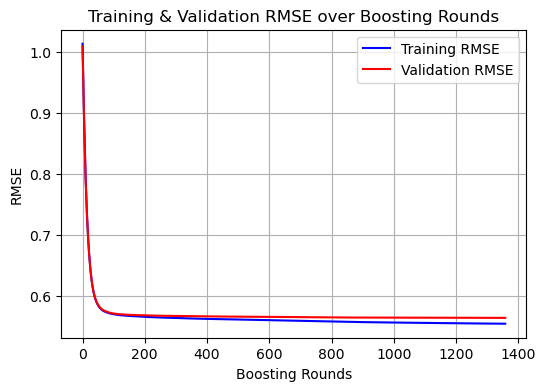

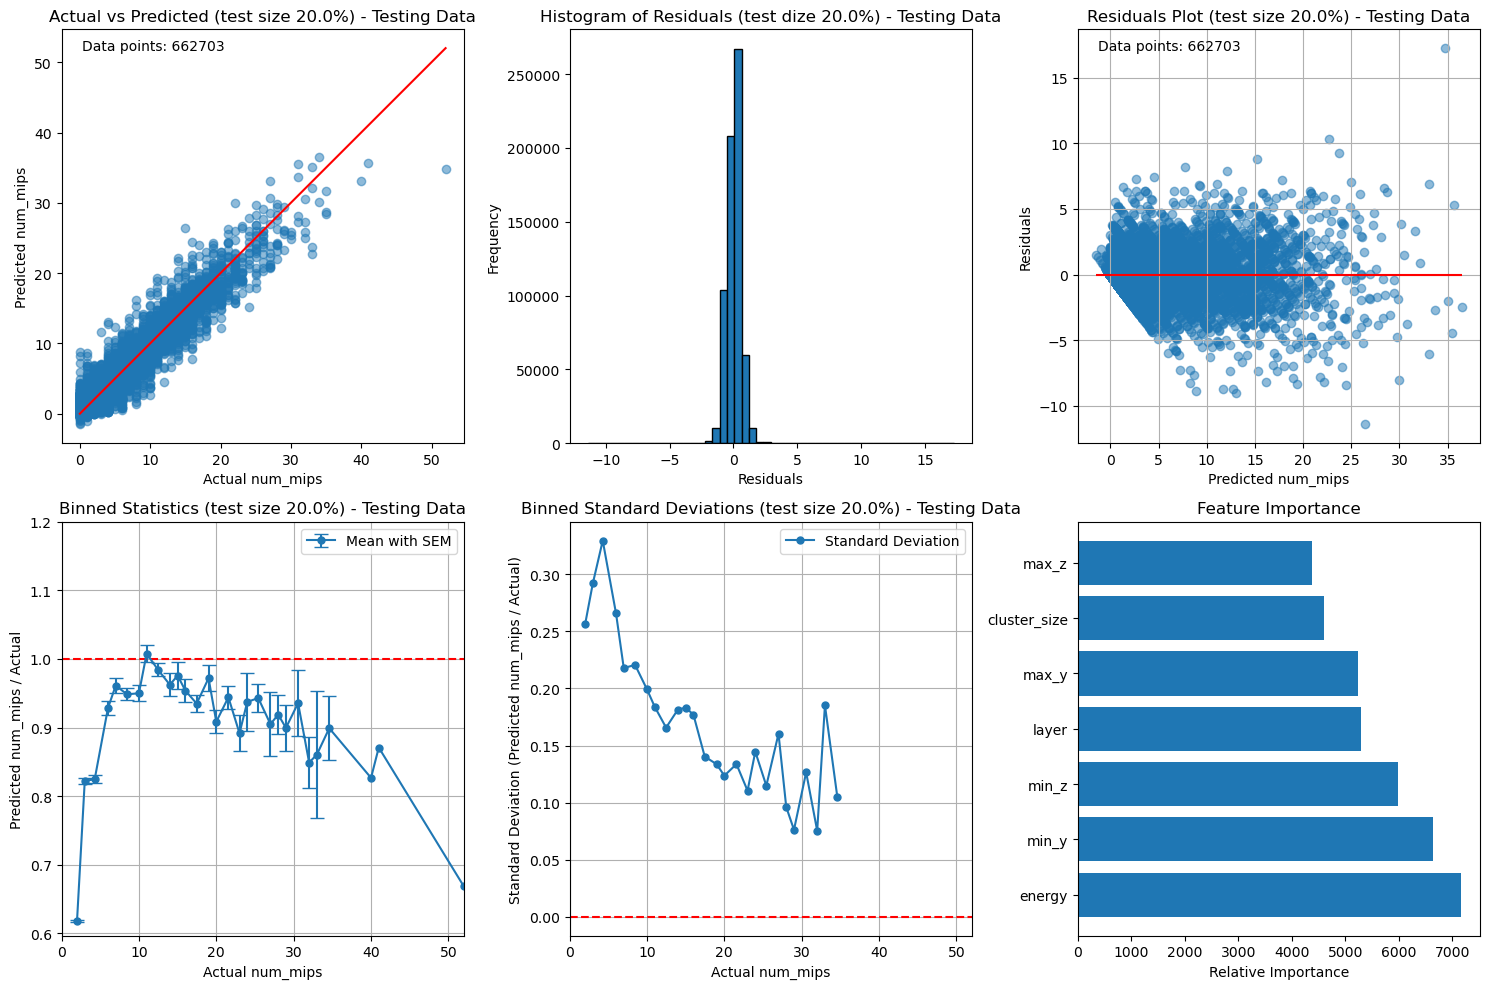

In [8]:
plot(bst, e, train_df, test_df, 0.2)

In [129]:
bst_noenergy, e, train_df, test_df  = trained_model(df.drop(columns = ["eventID", "energy"]))

/Users/jerry/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/jerry/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/jerry/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'eva

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1078
[LightGBM] [Info] Number of data points in the train set: 1988106, number of used features: 6
[LightGBM] [Info] Start training from score 0.710113
Training until validation scores don't improve for 50 rounds
[10]	training's rmse: 0.806562	valid_1's rmse: 0.804962
[20]	training's rmse: 0.69042	valid_1's rmse: 0.69059
[30]	training's rmse: 0.634969	valid_1's rmse: 0.635844
[40]	training's rmse: 0.610021	valid_1's rmse: 0.611144
[50]	training's rmse: 0.598183	valid_1's rmse: 0.59934
[60]	training's rmse: 0.592674	valid_1's rmse: 0.59397
[70]	training's rmse: 0.589564	valid_1's rmse: 0.590898
[80]	training's rmse: 0.587673	valid_1's rmse: 0.589055
[90]	training's rmse: 0.586388	valid_1's rmse: 0.587803
[100]	training's rmse: 0.5855

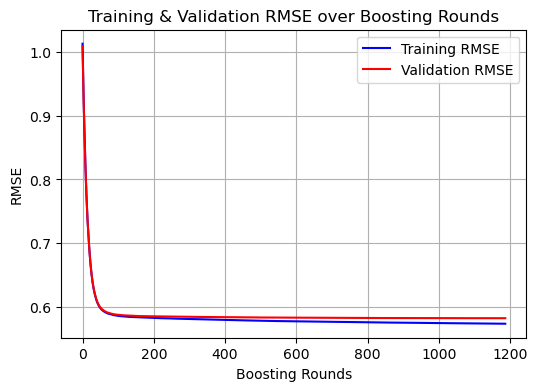

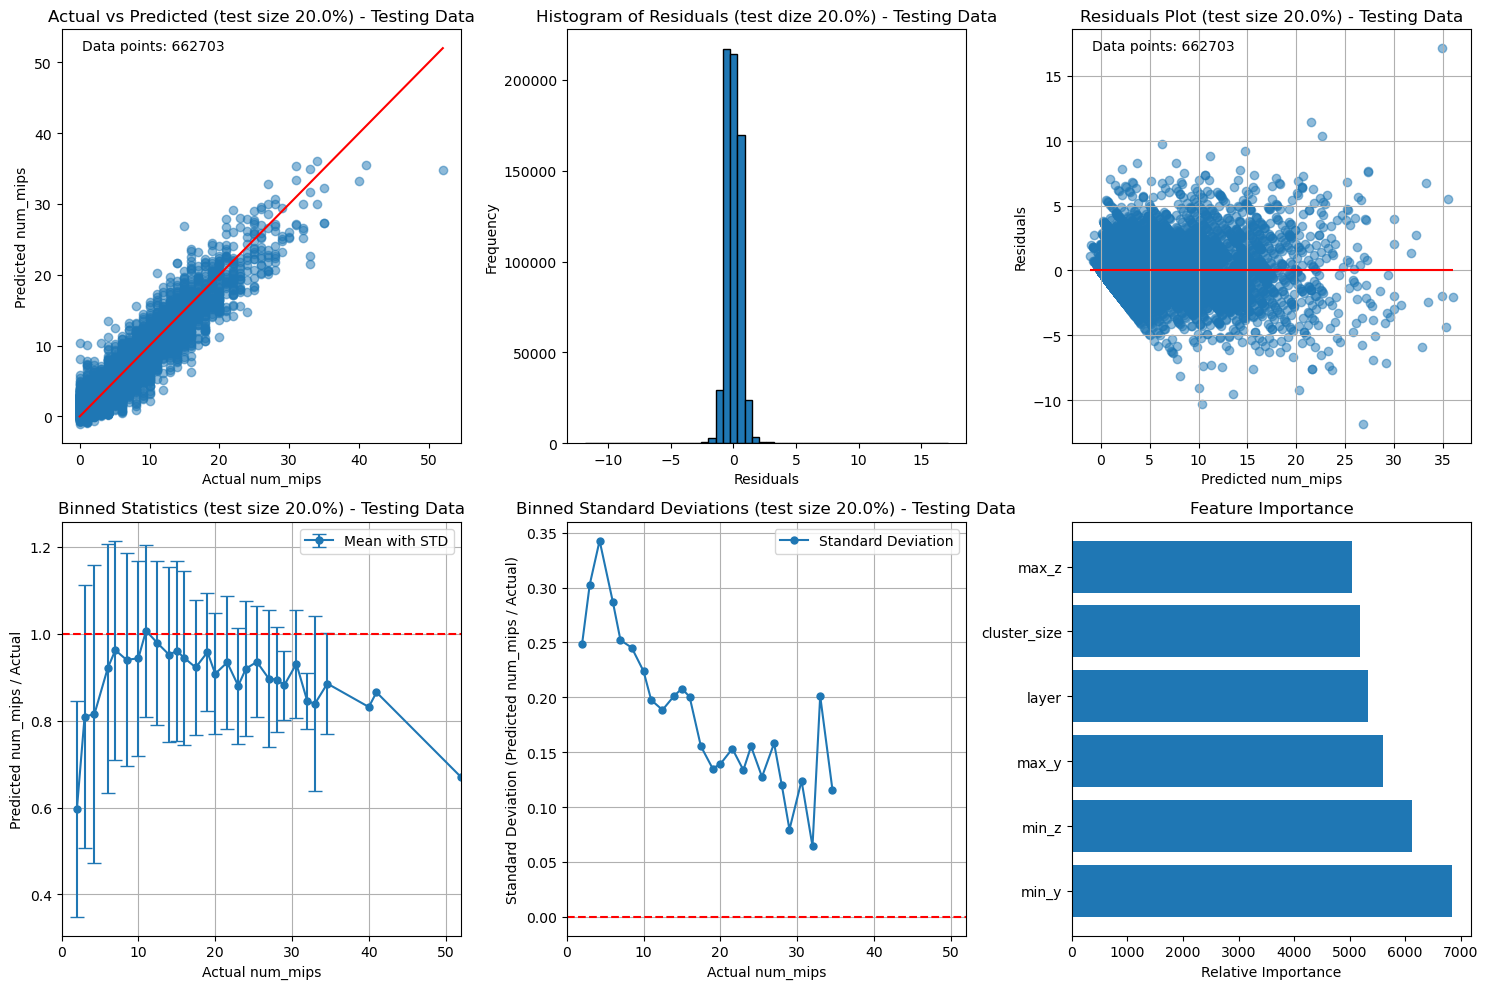

In [130]:
plot(bst_noenergy, e, train_df, test_df, 0.2)

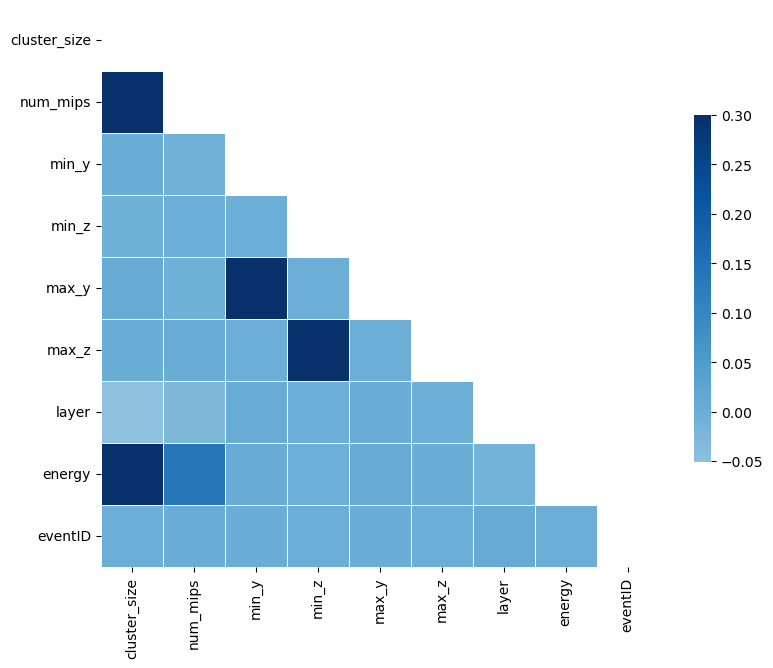

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='Blues', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


In [9]:
mips = pd.read_csv("mips.csv").query("sig > 2")
mips

,eventID,numHits,y_index,z_index,layer,sig,KE
0,0.0,-1408.0,1000.0,200.0,0.0,2.500000,0.500000
1,0.0,-1408.0,1000.0,200.0,1.0,2.500000,0.500000
2,0.0,-1408.0,1001.0,200.0,2.0,2.500000,0.500000
3,0.0,-1408.0,1004.0,199.0,3.0,2.500000,0.500000
4,0.0,-1408.0,1007.0,199.0,4.0,2.392254,0.392254
...,...,...,...,...,...,...,...
2783221,1999.0,-1392.0,1015.0,195.0,5.0,2.012881,0.012881
2783222,1999.0,-1392.0,1009.0,200.0,5.0,2.002604,0.002604
2783223,1999.0,-1392.0,669.0,318.0,7.0,2.002569,0.002569
2783224,1999.0,-1392.0,1108.0,160.0,5.0,2.002722,0.002722


In [219]:
def gaussian_plot(grouped_data, col = "num_mips"): 
    # Plotting histogram
    plt.figure(figsize=(10, 8))
    n, bins, patches = plt.hist(grouped_data[col], bins=20, density=False, alpha=0.7, label='Distribution of Mips',edgecolor='black')

    # Fitting the Gaussian to the bins of the histogram
    bin_centers = 0.5*(bins[:-1] + bins[1:])
    (mu, sigma) = norm.fit(grouped_data[col])

    # Adding the Gaussian fit line - we'll scale it to the histogram
    y = norm.pdf(bin_centers, mu, sigma)
    y = y * (bins[1] - bins[0]) * len(grouped_data[col])
    l = plt.plot(bin_centers, y, 'r--', linewidth=2)

    # Calculate standard deviation of mean and standard deviation
    std_of_mean = np.std(grouped_data[col]) / np.sqrt(len(grouped_data))
    std_of_std = sigma / np.sqrt(2 * len(grouped_data))

    plt.title(f'Gaussian fit results: mu = {mu:.2f} ± {std_of_mean:.2f}, sigma = {sigma:.2f} ± {std_of_std:.2f}')
    plt.xlabel('number of mips per event', fontsize=13)
    plt.ylabel('Number of Events', fontsize=13)
    plt.legend()
    
    plt.xlim([mu-150,mu+150])
    plt.ylim([0, 315])

    # Add statistics text to the plot
    plt.text(0.6, 0.9, f'Number of Events: {len(grouped_data)}', transform=plt.gca().transAxes, fontsize=12)
    plt.text(0.6, 0.85, f'Mean: {mu:.2f} ± {std_of_mean:.2f}', transform=plt.gca().transAxes, fontsize=12)
    plt.text(0.6, 0.8, f'Standard Deviation: {sigma:.2f} ± {std_of_std:.2f}', transform=plt.gca().transAxes, fontsize=12)
    
    plt.grid(True)
    plt.show()

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit

def gaussian(x, mu, sigma, height):
    return height * norm.pdf(x, mu, sigma)

def gaussian_plot(grouped_data, col="num_mips", width = 150):
    plt.figure(figsize=(10, 8))
    n, bins, patches = plt.hist(grouped_data[col], bins=20, density=False, alpha=0.7, label='Distribution of Mips', edgecolor='black')

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    popt, pcov = curve_fit(gaussian, bin_centers, n, p0=[np.mean(grouped_data[col]), np.std(grouped_data[col]), max(n)])
    mu, sigma, height = popt
    mu_err, sigma_err, _ = np.sqrt(np.diag(pcov))
    print(np.diag(pcov))
    l = plt.plot(bin_centers, gaussian(bin_centers, *popt), 'r--', linewidth=2)
    plt.title(f'Gaussian fit results: mu = {mu:.2f} ± {mu_err:.2f}, sigma = {sigma:.2f} ± {sigma_err:.2f}')
    plt.xlabel('number of mips per event', fontsize=13)
    plt.ylabel('Number of Events', fontsize=13)
    plt.legend()

    plt.xlim([mu - width, mu + width])
    plt.ylim([0, 315])
    
    resolution = sigma / mu * 100
    resolution_err = np.sqrt((1/mu * sigma_err)**2 + (-sigma/mu**2 * mu_err)**2) * 100
    plt.text(0.6, 0.75, f'Resolution: {resolution:.2f}% ± {resolution_err:.2f}%', transform=plt.gca().transAxes, fontsize=12)
    print(resolution_err)
    plt.text(0.6, 0.9, f'Number of Events: {len(grouped_data)}', transform=plt.gca().transAxes, fontsize=12)
    plt.text(0.6, 0.85, f'Mean: {mu:.2f} ± {mu_err:.2f}', transform=plt.gca().transAxes, fontsize=12)
    plt.text(0.6, 0.8, f'Standard Deviation: {sigma:.2f} ± {sigma_err:.2f}', transform=plt.gca().transAxes, fontsize=12)
    
    plt.grid(True)
    plt.show()


In [44]:
hits = pd.read_csv('true_hits.csv')
hits

,eventID,numHits,y_index,z_index,layer,n_neighbors,energy,neighbor_energy
0,0.0,2425.0,999.0,199.0,0.0,1.0,0.002457,0.0024
1,0.0,2425.0,1000.0,200.0,0.0,1.0,0.002457,0.0024
2,0.0,2425.0,993.0,162.0,1.0,0.0,0.002234,0.0000
3,0.0,2425.0,999.0,199.0,1.0,1.0,0.002625,0.0090
4,0.0,2425.0,1000.0,200.0,1.0,1.0,0.009064,0.0026
...,...,...,...,...,...,...,...,...
4963384,1999.0,2670.0,1399.0,72.0,39.0,1.0,0.001099,0.0000
4963385,1999.0,2670.0,1400.0,72.0,39.0,1.0,0.004028,0.0010
4963386,1999.0,2670.0,1400.0,72.0,39.0,1.0,0.004028,0.0000
4963387,1999.0,2670.0,1708.0,395.0,39.0,0.0,0.002136,0.0000


original hits
[9.73280637e+00 9.74071174e+00 3.36968635e+06]
0.12602906109355738


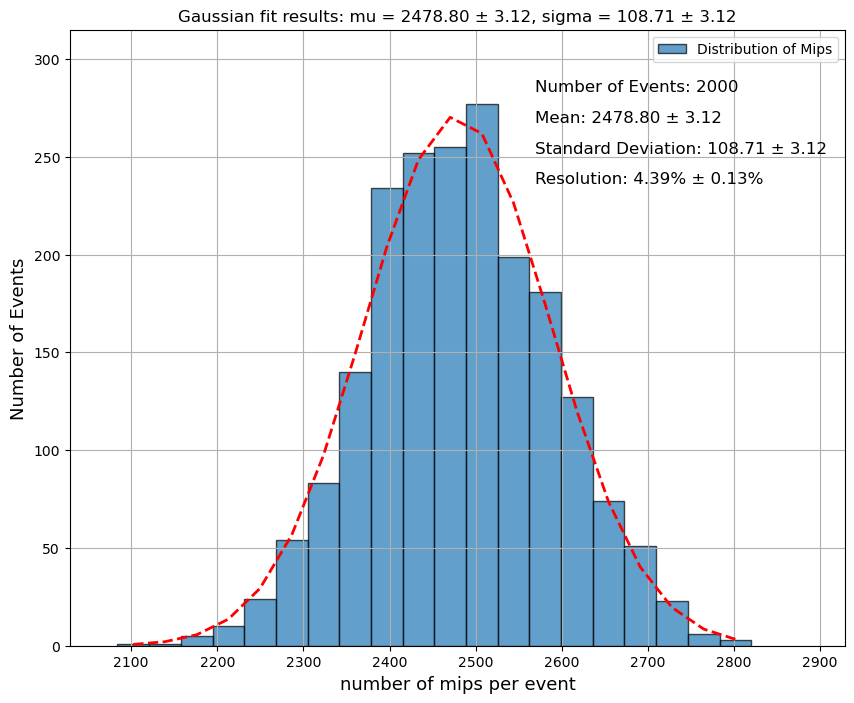

In [47]:
print("original hits")
grouped_data = hits.groupby('eventID').size().reset_index(name='counts')
gaussian_plot(grouped_data, 'counts', width = 450)

original mips with sig > 2
[8.23441036e-01 8.23736088e-01 3.12858504e+05]
0.07252159791517915


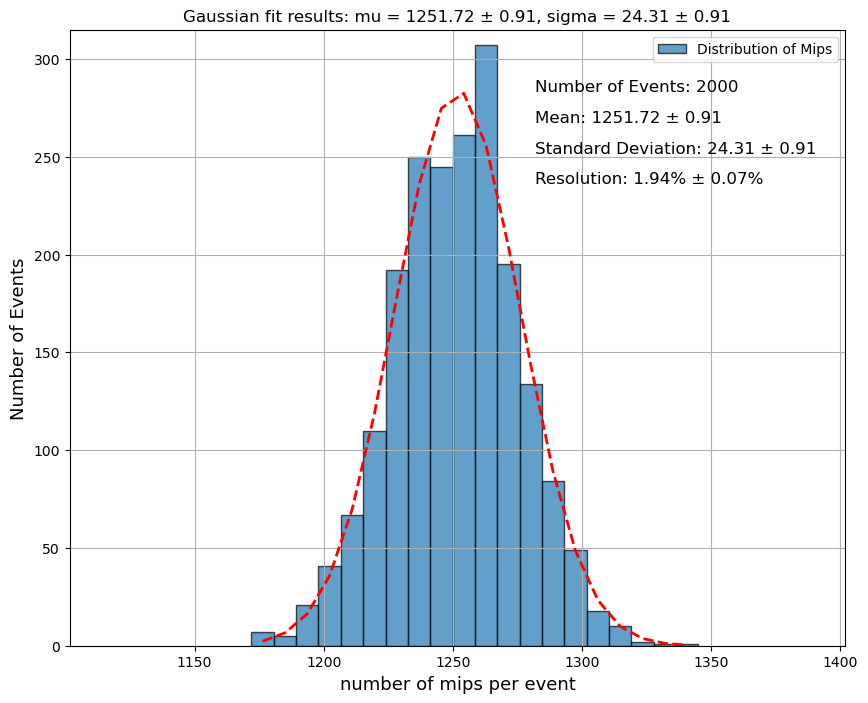

In [38]:
print("original mips with sig > 2")
grouped_data = mips.groupby('eventID').size().reset_index(name='counts')
gaussian_plot(grouped_data, 'counts')

double count odd rows of mips with sig > 2
[  0.82399551   0.82440024 463.45650625]


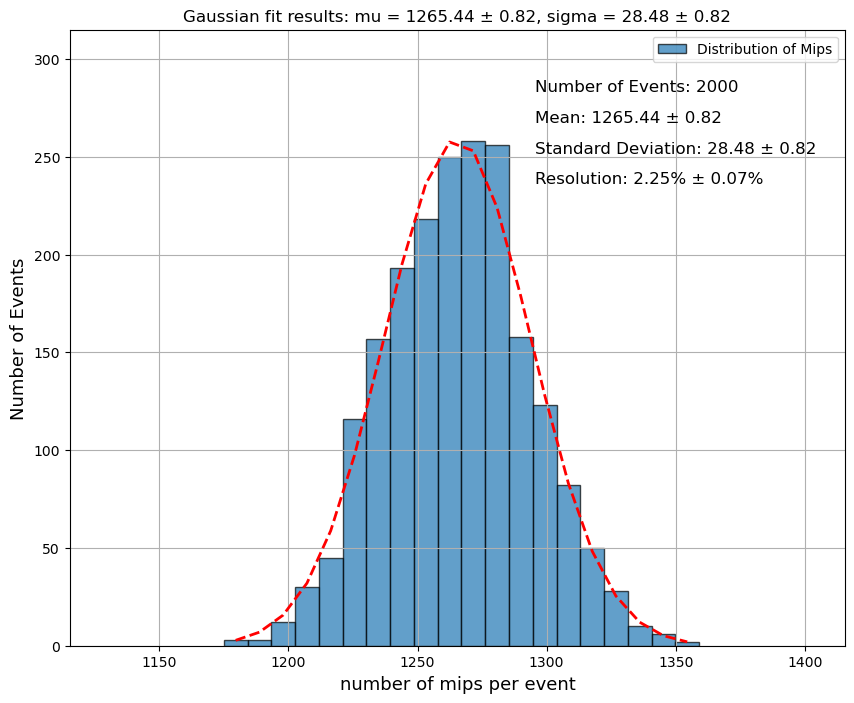

In [26]:
print("double count odd rows of mips with sig > 2")
# Filter rows with layer > 20 and being even
filtered_mips = mips[(mips['layer'] <= 20) | (mips['layer'] % 2 == 1)]

# Duplicate rows with layer > 20 and being odd
odd_rows = mips[(mips['layer'] > 20) & (mips['layer'] % 2 == 1)]
filtered_mips = pd.concat([filtered_mips, odd_rows])

# Group and plot
grouped_data = filtered_mips.groupby('eventID').size().reset_index(name='counts')
gaussian_plot(grouped_data, col='counts')


check that my cluster data agrees in counting mips
[  0.89690761   0.89776109 554.81830759]


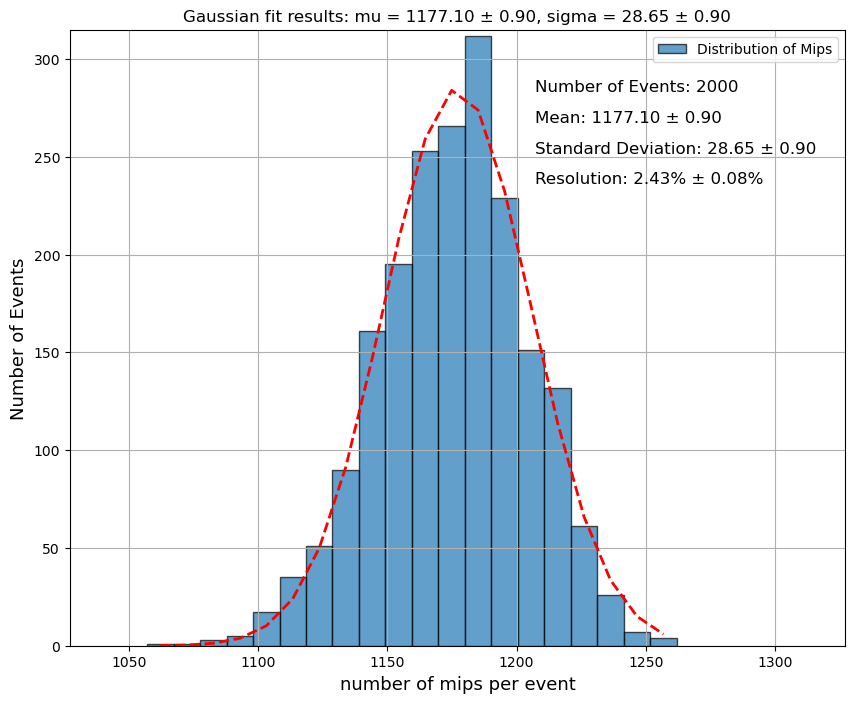

In [27]:
print("check that my cluster data agrees in counting mips")

grouped_data = df.groupby('eventID')['num_mips'].sum().reset_index(name='sum_num_mips')

# then plot
gaussian_plot(grouped_data, col='sum_num_mips')



In [28]:
df_with_pred = df
df_with_pred["predicted"] = bst.predict(df.drop(columns = ["eventID", "num_mips"]))

testing predicted
[3.48572355e-01 3.48839504e-01 1.12666752e+05]
0.05025071522286379


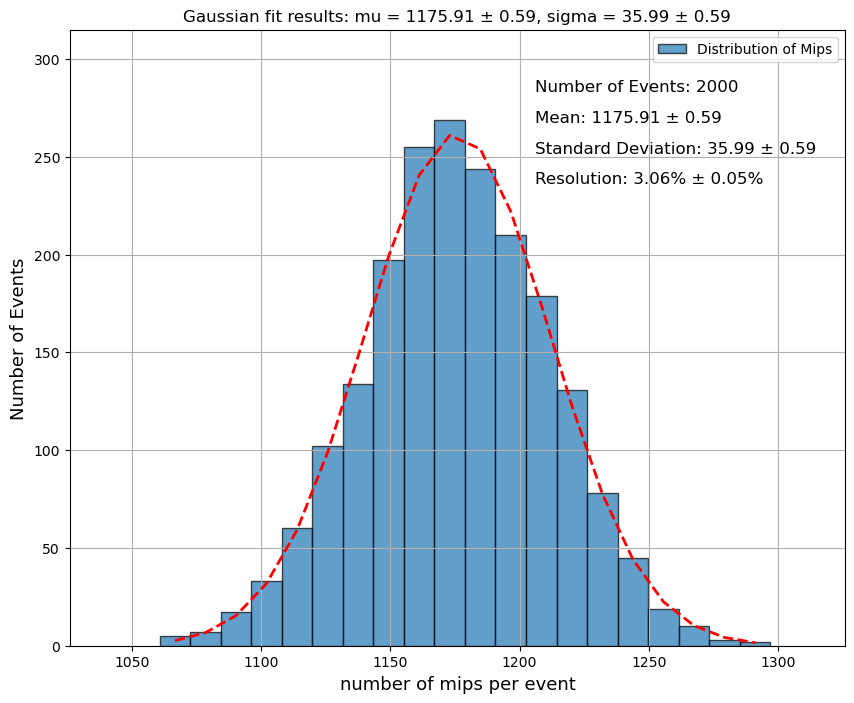

In [40]:
print("testing predicted")
grouped_data = df_with_pred.groupby('eventID')['predicted'].sum().reset_index(name='sum_num_mips')
gaussian_plot(grouped_data, col='sum_num_mips')

show cluster distribution
[2.49153263e+00 2.49211778e+00 9.51635521e+05]
0.0870688598778323


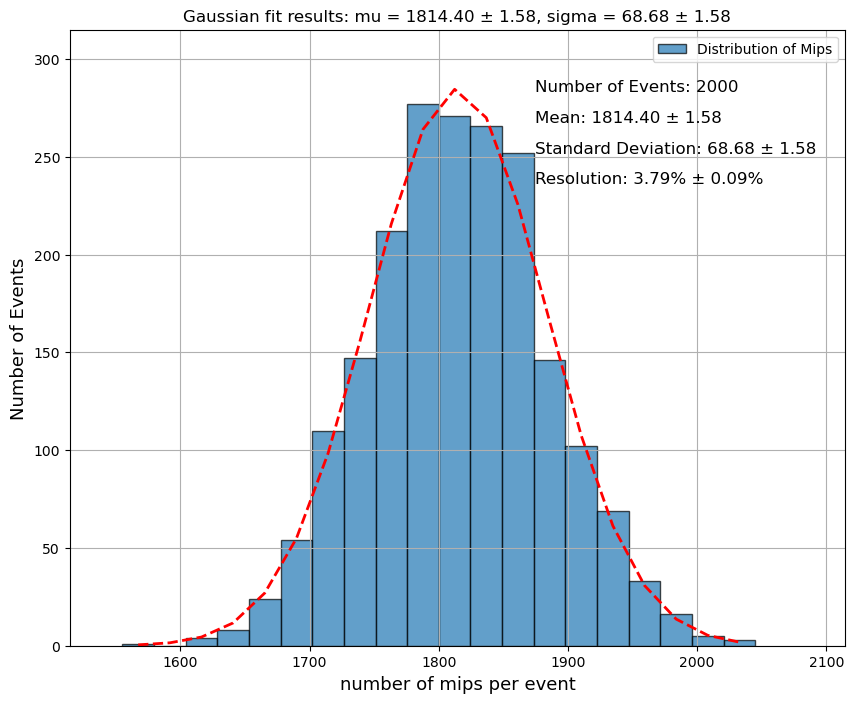

In [43]:
print("show cluster distribution")
# Filter rows with layer > 20 and being even
filtered_df = df[(df['layer'] <= 20) | (df['layer'] % 2 == 1)]

# Duplicate rows with layer > 20 and being odd
odd_rows = df[(df['layer'] > 20) & (df['layer'] % 2 == 1)]
filtered_df = pd.concat([filtered_df, odd_rows])

# Group and plot
grouped_data = filtered_df.groupby('eventID').size().reset_index(name='counts')
gaussian_plot(grouped_data, col='counts', width = 300)


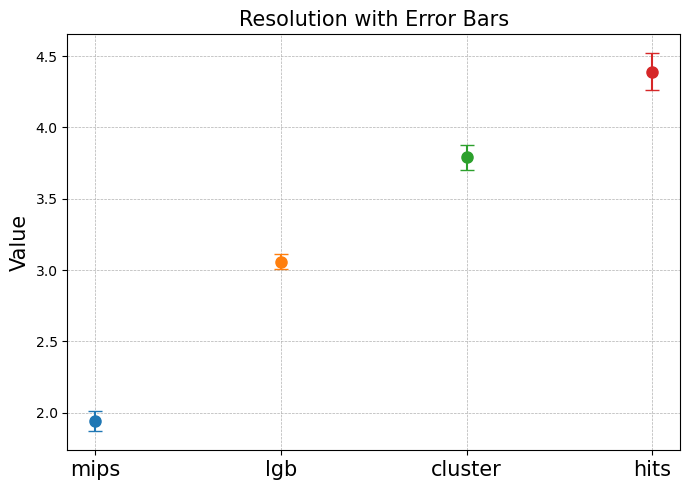

In [55]:
import matplotlib.pyplot as plt

# Data
labels = ['mips', 'lgb', 'cluster', 'hits']
values = [1.94, 3.06, 3.79, 4.39]
errors = [0.07, 0.05, 0.09, 0.13]

# Plotting
plt.figure(figsize=(7, 5))
for i, label in enumerate(labels):
    plt.errorbar(i, values[i], yerr=errors[i], fmt='o', capsize=5, label=label, markersize=8)

plt.xticks(range(len(labels)), labels, fontsize = 15)
plt.ylabel("Value", fontsize = 15)
plt.title("Resolution with Error Bars", fontsize = 15)
# plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


In [55]:
ts = 0.9
lgb_model, X_train, X_test, y_train, y_test = trained_lgb(data, ts)
train_pred = lgb_model.predict(X_train.drop(columns = ['eventID']))
test_pred = lgb_model.predict(X_test.drop(columns = ['eventID']))

In [56]:
X_train["predicted_mips_lgb"] = train_pred
X_train["num_mips"] = y_train
X_test["predicted_mips_lgb"] = test_pred
X_test["num_mips"] = y_test